In [1]:
import torch
import tonic
import norse
import nir
import numpy as np
from collections import defaultdict
import tqdm

In [2]:
nir_graph = nir.read("scnn_mnist.nir")
{k: type(v) for k, v in nir_graph.nodes.items()}

{'0': nir.ir.Conv2d,
 '1': nir.ir.IF,
 '10': nir.ir.IF,
 '11': nir.ir.Affine,
 '12': nir.ir.IF,
 '2': nir.ir.Conv2d,
 '3': nir.ir.IF,
 '4': nir.ir.SumPool2d,
 '5': nir.ir.Conv2d,
 '6': nir.ir.IF,
 '7': nir.ir.SumPool2d,
 '8': nir.ir.Flatten,
 '9': nir.ir.Affine,
 'input': nir.ir.Input,
 'output': nir.ir.Output}

In [3]:
g = norse.torch.from_nir(nir_graph)

In [5]:
to_frame = tonic.transforms.ToFrame(sensor_size=tonic.datasets.NMNIST.sensor_size, time_window = 1e3)
dataset = tonic.datasets.NMNIST(".", transform=to_frame, train=False)
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=10, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [12]:
def evaluate(x):
    out = []
    state = None
    for t in x:
        z, state = g(t, state)
        out.append(z)
    return torch.stack(out).mean(0)
evaluate(torch.from_numpy(dataset[0][0]).float().unsqueeze(0)).shape

torch.Size([307, 10])

In [56]:
losses = []
accuracies = []
with torch.no_grad():
    for batch in (pb := tqdm.tqdm(loader)):
        x, y = batch
        pred = evaluate(x)
        acc = pred.argmax(1) == y
        accuracies.append(acc)
        loss = torch.nn.functional.cross_entropy(pred, y)
        losses.append(loss)
        acc_tensor = torch.stack(accuracies).flatten()
        pb.set_description(f"Acc {acc_tensor.sum() / len(acc_tensor)}")
print(torch.stack(losses).mean())

Acc 0.9811000227928162: 100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [10:23<00:00,  1.61it/s]

tensor(2.0545)


# Calculate and save accuracy

In [57]:
acc_tensor = torch.stack(accuracies).flatten()
acc_tensor.sum() / len(acc_tensor)

tensor(0.9811)

In [58]:
np.save("norse_accuracy.npy", (acc_tensor.sum() / len(acc_tensor)).numpy())

# Record activity for first datapoint

In [14]:
children = list(g.children())
state = None
out = []
for t in np.load("val_numbers.npy"):
    x = children[0](torch.tensor(t, dtype=torch.float32))
    y, state = children[1](x, state)
    out.append(y)
out = torch.stack(out)

In [18]:
np.save("Norse_activity.npy", out.detach().numpy())

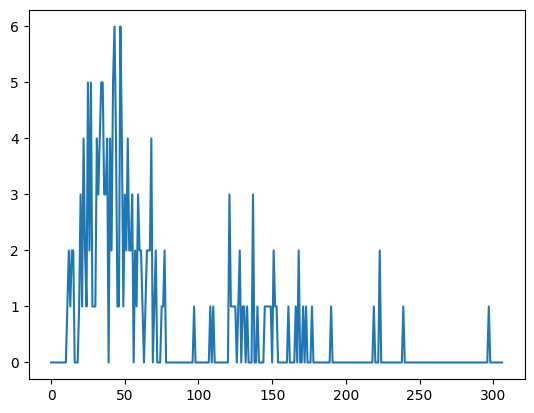

In [64]:
import matplotlib.pyplot as plt
plt.plot(recorded.flatten(1).sum(1))